# ECE-6524 / CS-6524 Deep Learning
# Assignment 4

In this assignment, **you will implement the following:**
1. GAN / LSGAN loss functions and training code for MNIST dataset
2. Train GAN / LSGAN on CelebA dataset with DCGAN architectures

**<span style="color:red">Again, it may take hours to train on CelebA. So start early.</span>**

This assignment is inspired and adapted from UIUC CS498 and Stanford CS231n.
## Submission guideline
1. Click the Save button at the top of the Jupyter Notebook.
2. Please make sure to have entered your Virginia Tech PID below.
3. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of cells).
4. Select Cell -> Run All. This will run all the cells in order.
5. Once you've rerun everything, select File -> Download as -> PDF via LaTeX
6. Look at the PDF file and make sure all your solutions are displayed correctly there. 
7. Zip the all the files along with this notebook (Please don't include the data)
8. Name your PDF file as Assignment2_[YOUR ID NUMBER].
9. Submit your zipped file and the PDF **INDEPENDENTLY**.
10. **PLEASE DO NOT ZIP YOUR DATASET. NOTEBOOK/CODE/PDF ONLY.**

**While you are encouraged to discuss with your peers, <span style="color:blue">all work submitted is expected to be your own.</span> <span style="color:red">If you use any information from other resources (e.g. online materials), you are required to cite it below you VT PID. Any violation will result in a 0 mark for the assignment.</span>**

# Section 1. Generative Adversarial Networks on MNIST Dataset [50 pts]

In this section, you will need to:
1. Implement two different types of loss functions (GAN / LSGAN) for generative adversarial networks. 
2. Implement training codes for you GAN models.
3. Train and verify your model on MNIST dataset.

Now, let's get started!

In [3]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [4]:
# set your device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Section 1.1. Vanilla GAN loss functions

### Section 1.1.1 GAN Loss [10 pts]
We start from implementing the vanilla GAN loss from the [original GAN paper](https://arxiv.org/pdf/1406.2661.pdf). Specifically, you need to complete the `generator_loss` and `discriminator_loss` in the cell below.

Recalled from the class, the generator loss is written as:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these equations could be silghtly different from what we have seen before. This is because that in Pytorch, our optimize will be *minimizing* the loss functions. As a result, we negate the formulas to match pytorch's behavior.

**HINTS**: You should use the `torch.nn.functional.binary_cross_entropy_with_logits` function to compute the binary cross entropy loss since it is more numerically stable than using a softmax followed by BCE loss. The BCE loss is needed to compute the log probability of the true label given the logits output from the discriminator. Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross entropy loss is

$$ bce(s, y) = -y * \log(s) - (1 - y) * \log(1 - s) $$


Instead of computing the expectation of $\log D(G(z))$, $\log D(x)$ and $\log \left(1-D(G(z))\right)$, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [43]:
def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss.
 
    You should use the stable torch.nn.functional.binary_cross_entropy_with_logits
    loss rather than using a separate softmax function followed by the binary cross
    entropy loss.
 
    Inputs:
    - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
 
    Returns:
    - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
    """
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    ones = torch.ones_like(logits_real).to(device)
    zeros = torch.zeros_like(logits_fake).to(device)
    real_loss = torch.nn.functional.binary_cross_entropy_with_logits(input=logits_real, target=ones, reduce=True)
    fake_loss = torch.nn.functional.binary_cross_entropy_with_logits(input=logits_fake, target=zeros, reduce=True)
    loss = real_loss + fake_loss
    ##########       END      ##########
    return loss

def generator_loss(logits_fake):
    """
    Computes the generator loss.

    You should use the stable torch.nn.functional.binary_cross_entropy_with_logits
    loss rather than using a separate softmax function followed by the binary cross
    entropy loss.

    Inputs:
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """

    loss = None
 
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    ones = torch.ones_like(logits_fake).to(device)
    # D(G(Z)) is discriminator's estimate of the probability that a fake instance is real.
    loss = torch.nn.functional.binary_cross_entropy_with_logits(input=logits_fake, target=ones, reduce=True)
    
    ##########       END      ##########
    return loss

### Section 1.1.2 Training code [10 pts]
You can't train a model without a proper training code. Implement the GAN training procedure here following the [original GAN paper](https://arxiv.org/pdf/1406.2661.pdf) and the course slides in the cell below. Note that this code would be reused in the subsequent section, so make sure that it is correctly implemented.

In [44]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
 
from gan.utils import sample_noise, show_images, deprocess_img, preprocess_img
 
def train(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250,
              batch_size=128, noise_size=100, num_epochs=10, train_loader=None, device=None):
    """
    Train loop for GAN.

    The loop will consist of two steps: a discriminator step and a generator step.

    (1) In the discriminator step, you should zero gradients in the discriminator
    and sample noise to generate a fake data batch using the generator. Calculate
    the discriminator output for real and fake data, and use the output to compute
    discriminator loss. Call backward() on the loss output and take an optimizer
    step for the discriminator.

    (2) For the generator step, you should once again zero gradients in the generator
    and sample noise to generate a fake data batch. Get the discriminator output
    for the fake data batch and use this to compute the generator loss. Once again
    call backward() on the loss and take an optimizer step.

    You will need to reshape the fake image tensor outputted by the generator to
    be dimensions (batch_size x input_channels x img_size x img_size).

    Use the sample_noise function to sample random noise, and the discriminator_loss
    and generator_loss functions for their respective loss computations

    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    - train_loader: image dataloader
    - device: PyTorch device
    """
    iter_count = 0
    for epoch in range(num_epochs):
        print('EPOCH: ', (epoch+1))
        for x, _ in train_loader:
            _, input_channels, img_size, _ = x.shape

            real_images = preprocess_img(x).to(device)  # normalize

            # Store discriminator loss output, generator loss output, and fake image output
            # in these variables for logging and visualization below
            d_error = None
            g_error = None
            fake_images = None


            ####################################
            #        Discriminator step        #
            #          YOUR CODE HERE          #
            ####################################
            D_solver.zero_grad()
            prior = sample_noise(batch_size, noise_size)
#             import pdb; pdb.set_trace()
            fake_images = G(prior.to(device))           
            logits_real = D(x.to(device))
            logits_fake = D(fake_images.view_as(x))
            d_error = discriminator_loss(logits_real, logits_fake)
            d_error.backward()
            D_solver.step()

            #########       END      ###########
 
            ####################################
            #          Generator step          #
            #          YOUR CODE HERE          #
            ####################################
            G_solver.zero_grad()
            prior = sample_noise(batch_size, noise_size)
            fake_images = G(prior.to(device))            
            logits_fake = D(fake_images.view_as(x))
            
            g_error = generator_loss(logits_fake)
            g_error.backward()
            G_solver.step()
            
            ##########       END      ##########
            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_error.item(),g_error.item()))
                disp_fake_images = deprocess_img(fake_images.data)  # denormalize
                imgs_numpy = (disp_fake_images).cpu().numpy()
                show_images(imgs_numpy[0:16], color=input_channels!=1)
                plt.show()
                print()
            iter_count += 1

### Section 1.1.3 Training on MNIST [10 pts]
MNIST is a simple dataset that contains one hand-written digit in each image. It is usually used for sanity check. So, let's test our loss functions and training code on it!

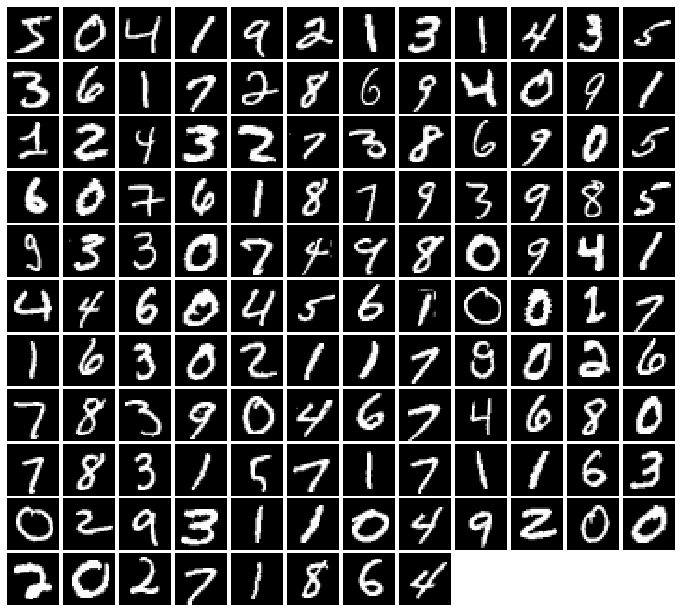

In [7]:
NOISE_DIM = 100
batch_size = 128

mnist = datasets.MNIST('./MNIST_data', train=True, download=True,
                           transform=transforms.ToTensor())
loader_train = DataLoader(mnist, batch_size=batch_size, drop_last=True)


imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

Here, we provide a pre-defined discriminator and generator for you. Note that in section 2, you have to implement the discriminator and generator yourself.

In [8]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
def discriminator():
    """
    Initialize and return a simple discriminator model.
    """
    model = torch.nn.Sequential( Flatten(),
                                torch.nn.Linear(784, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 1)
    )
    return model

def generator(noise_dim=NOISE_DIM):
    """
    Initialize and return a simple generator model.
    """
    
    model = nn.Sequential(
        torch.nn.Linear(noise_dim, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 784),
        torch.nn.Tanh()
    )

    return model

Run the cell belowe to train your GAN model. You should expect results that resemble the following if your loss function and training loop implementations are correct:

<img src="files/gan_samples/mnist_gan.jpg" width=300>

EPOCH:  1
Iter: 0, D: 1.377, G:0.6897


/home/sengming/.local/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


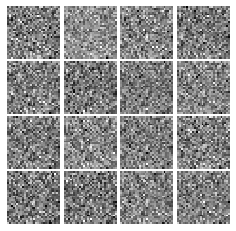


Iter: 250, D: 0.5235, G:2.64


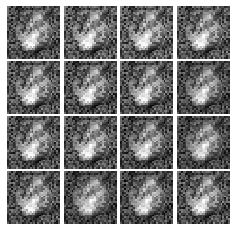


EPOCH:  2
Iter: 500, D: 0.8723, G:1.839


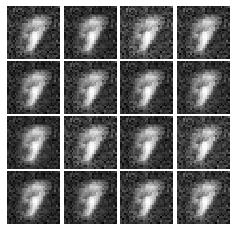


Iter: 750, D: 0.9278, G:2.006


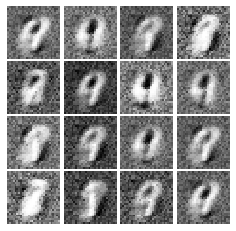


EPOCH:  3
Iter: 1000, D: 0.8397, G:2.107


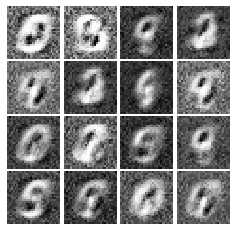


Iter: 1250, D: 0.7542, G:1.935


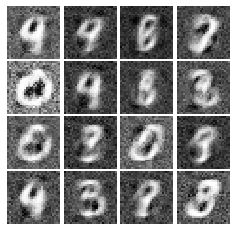


EPOCH:  4
Iter: 1500, D: 0.7575, G:1.923


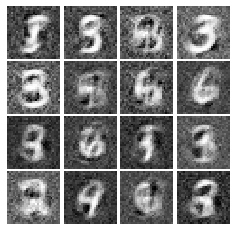


Iter: 1750, D: 0.9841, G:1.528


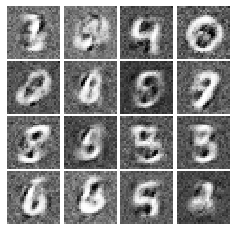


EPOCH:  5
Iter: 2000, D: 0.8475, G:2.04


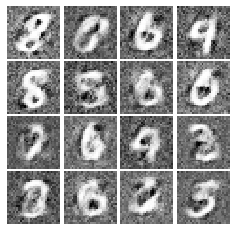


Iter: 2250, D: 1.006, G:1.7


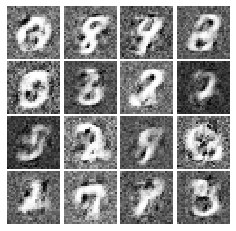


EPOCH:  6
Iter: 2500, D: 0.8711, G:2.213


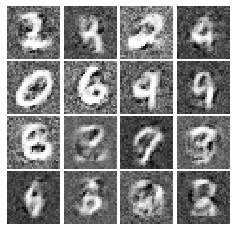


Iter: 2750, D: 0.8156, G:1.949


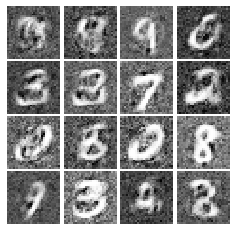


EPOCH:  7
Iter: 3000, D: 0.822, G:2.197


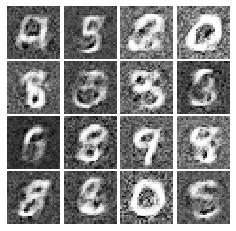


Iter: 3250, D: 0.7664, G:2.381


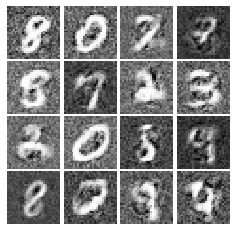


EPOCH:  8
Iter: 3500, D: 0.8107, G:2.218


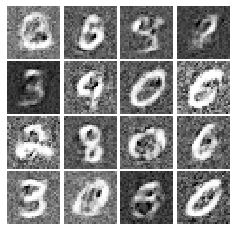


EPOCH:  9
Iter: 3750, D: 0.7923, G:2.671


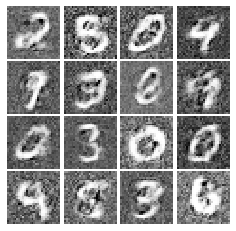


Iter: 4000, D: 0.7446, G:2.805


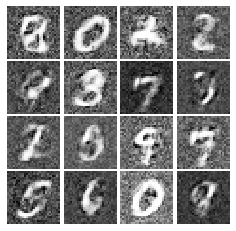


EPOCH:  10
Iter: 4250, D: 0.653, G:2.812


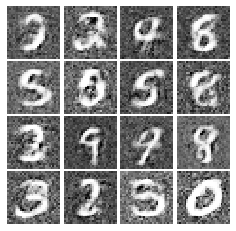


Iter: 4500, D: 0.6738, G:2.031


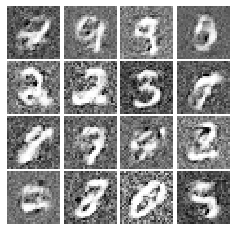

In [9]:
# original GAN
D = discriminator().to(device)
G = generator().to(device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D, G, D_optimizer, G_optimizer, discriminator_loss, generator_loss, train_loader=loader_train, num_epochs=10, device=device)

## Section 1.2 Least-square GAN Loss
### Section 1.2.1 LSGAN Loss [10 pts]
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$
Fill in the `ls_discriminator_loss` and `ls_generator_loss` in the cell below.

**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`scores_real` and `scores_fake`).

In [10]:
def ls_discriminator_loss(scores_real, scores_fake):
    """
    Computes the discriminator loss.
 
    You should use the stable torch.nn.functional.binary_cross_entropy_with_logits
    loss rather than using a separate softmax function followed by the binary cross
    entropy loss.
 
    Inputs:
    - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
 
    Returns:
    - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
    """
 
    loss = None
    
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    real_loss = torch.mean((scores_real-1).pow(2), dim=0)
    fake_loss = torch.mean((scores_fake).pow(2), dim=0)
    
    loss = 0.5*(real_loss + fake_loss)
    
    ##########       END      ##########
    return loss

def ls_generator_loss(scores_fake):
    """
    Computes the generator loss.

    You should use the stable torch.nn.functional.binary_cross_entropy_with_logits
    loss rather than using a separate softmax function followed by the binary cross
    entropy loss.

    Inputs:
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """

    loss = None
 
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    loss = torch.mean((scores_fake - 1).pow(2), dim=0)
    ##########       END      ##########
    return loss

### Section 1.2.2 Train LSGAN [10 pts]
Similarly, train your LSGAN on MNIST dataset. You should expect results that resemble the following if your loss function and training loop implementations are correct:

<img src="files/gan_samples/mnist_ls.jpg" width=300>

In [36]:
# YOUR TRAINING CODE HERE            
# LS GAN
D = discriminator().to(device)
G = generator().to(device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D, G, D_optimizer, G_optimizer, ls_discriminator_loss, ls_generator_loss, train_loader=loader_train, num_epochs=10, device=device)

EPOCH:  1
> <ipython-input-34-16355b27e5d7>(65)train()
-> fake_images = G(prior.to(device))
(Pdb) p x.shape
torch.Size([128, 1, 28, 28])
(Pdb) p prior.shape
torch.Size([128, 100])
(Pdb) q


BdbQuit: 

# Section 2. Generative Adversarial Networks on CelebA Dataset [50 pts]

In this section, you will need to:
1. Implement DCGAN architecture
2. Train it on CelebA dataset.

We are done with the simple, not-so-challenging MNIST dataset. Now, you need to implement a specific model architecture call [DCGAN](https://arxiv.org/pdf/1511.06434.pdf), and train your model to generate human faces!

### Section 2.1. GAN model architecture [20 pts]

Implement your generator and discriminator for generating faces. We recommend the following architectures which are inspired by [DCGAN](https://arxiv.org/pdf/1511.06434.pdf):
**Discriminator:**

- convolutional layer with in_channels=3, out_channels=128, kernel=4, stride=2
- convolutional layer with in_channels=128, out_channels=256, kernel=4, stride=2
- batch norm
- convolutional layer with in_channels=256, out_channels=512, kernel=4, stride=2
- batch norm
- convolutional layer with in_channels=512, out_channels=1024, kernel=4, stride=2
- batch norm
- convolutional layer with in_channels=1024, out_channels=1, kernel=4, stride=1

Instead of Relu we LeakyReLu throughout the discriminator (we use a negative slope value of 0.2). 

The output of your discriminator should be a single value score corresponding to each input sample. See `torch.nn.LeakyReLU`.


**Generator:**

**Note:** In the generator, you will need to use transposed convolution (sometimes known as fractionally-strided convolution or deconvolution). This function is implemented in pytorch as `torch.nn.ConvTranspose2d`.

- transpose convolution with in_channels=NOISE_DIM, out_channels=1024, kernel=4, stride=1
- batch norm
- transpose convolution with in_channels=1024, out_channels=512, kernel=4, stride=2
- batch norm
- transpose convolution with in_channels=512, out_channels=256, kernel=4, stride=2
- batch norm
- transpose convolution with in_channels=256, out_channels=128, kernel=4, stride=2
- batch norm
- transpose convolution with in_channels=128, out_channels=3, kernel=4, stride=2

The output of the final layer of the generator network should have a `tanh` nonlinearity to output values between -1 and 1. The output should be a 3x64x64 tensor for each sample (equal dimensions to the images from the dataset).





In [61]:
# YOUR GENERATOR/DISCRIMINATOR HERE
class DC_Generator(nn.Module):
    def __init__(self, noise_dim):
        super().__init__()
        self.tconv0 = torch.nn.ConvTranspose2d(in_channels=noise_dim, out_channels=1024, kernel_size=4, stride=1, bias=False)
        self.bn0    = torch.nn.BatchNorm2d(num_features=1024)
        
        self.tconv1 = torch.nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, bias=False)
        self.bn1    = torch.nn.BatchNorm2d(num_features=512)
        
        self.tconv2 = torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, bias=False)
        self.bn2    = torch.nn.BatchNorm2d(num_features=256)
        
        self.tconv3 = torch.nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, bias=False)
        self.bn3    = torch.nn.BatchNorm2d(num_features=128)
        
        self.tconv4 = torch.nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=4, stride=2, bias=False)
        
        self.relu   = torch.nn.ReLU()
        self.tanh   = torch.nn.Tanh()
        
    def forward(self, x):
#         import pdb; pdb.set_trace()
        x = torch.unsqueeze(x,-1)
        x = torch.unsqueeze(x,-1)
        x = self.relu(self.bn0(self.tconv0(x)))
        x = self.relu(self.bn1(self.tconv1(x)))
        x = self.relu(self.bn2(self.tconv2(x)))
        x = self.relu(self.bn3(self.tconv3(x)))
        x = self.tanh(self.tconv4(x))
        
        return x
        
        
class DC_Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv0 = torch.nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4, stride=2)
        
        self.conv1 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2)
        self.bn1   = torch.nn.BatchNorm2d(num_features=256)
        
        self.conv2 = torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2)
        self.bn2   = torch.nn.BatchNorm2d(num_features=512)
        
        self.conv3 = torch.nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2)
        self.bn3   = torch.nn.BatchNorm2d(num_features=1024)
        
        self.conv4 = torch.nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=4, stride=1)
        
        self.leakyrelu = torch.nn.LeakyReLU(negative_slope=0.2)
        
    def forward(self, x):
        x = self.leakyrelu(self.conv0(x))
        x = self.leakyrelu(self.bn1(self.conv1(x)))
        x = self.leakyrelu(self.bn2(self.conv2(x)))
        x = self.leakyrelu(self.bn3(self.conv3(x)))
        x = self.leakyrelu(self.conv4(x))
        
        return x

### Section 2.2 Data loading: Celeb A Dataset

The CelebA images we provide have been filtered to obtain only images with clear faces and have been cropped and downsampled to 128x128 resolution.

In [46]:
batch_size = 128
scale_size = 64  # We resize the images to 64x64 for training

celeba_root = 'celeba_data'

In [47]:
celeba_train = ImageFolder(root=celeba_root, transform=transforms.Compose([
  transforms.Resize(scale_size),
  transforms.ToTensor(),
]))

celeba_loader_train = DataLoader(celeba_train, batch_size=batch_size, drop_last=True)

#### Visualize dataset

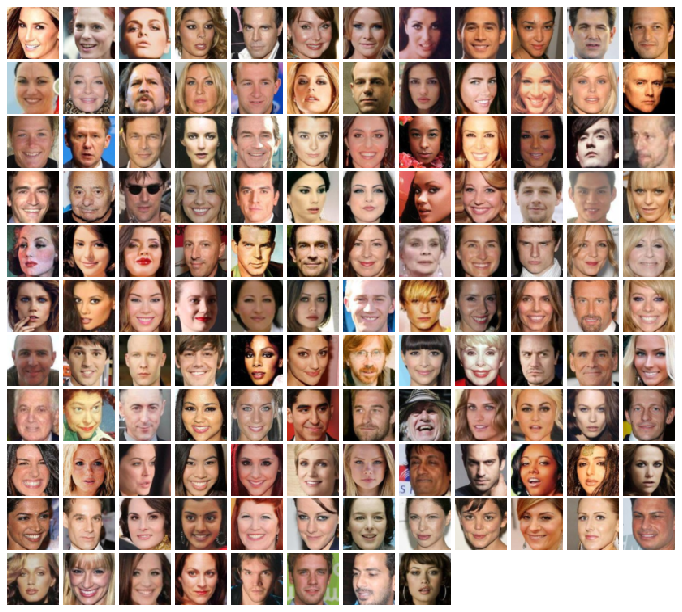

In [48]:
imgs = celeba_loader_train.__iter__().next()[0].numpy().squeeze()
show_images(imgs, color=True)

### Section 2.3 Train a Vanilla GAN on CelebA [10 pts]
Now, train your GAN model with vanilla GAN loss. If you models are implemented correctly, you should see something like this:
<img src="files/gan_samples/celeba.jpg" width=300>


Now, train your model. **Observe the visualized result of your model, and describe what you see.**

In [49]:
NOISE_DIM = 100
NUM_EPOCHS = 50
learning_rate = 0.0002

In [62]:
D = DC_Discriminator().to(device)
G = DC_Generator(noise_dim=NOISE_DIM).to(device)

In [63]:
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate, betas = (0.5, 0.999))

In [64]:
# original gan
train(D, G, D_optimizer, G_optimizer, discriminator_loss, 
          generator_loss, num_epochs=NUM_EPOCHS, show_every=250,
          train_loader=celeba_loader_train, device=device)


EPOCH:  1


RuntimeError: CUDA out of memory. Tried to allocate 62.00 MiB (GPU 0; 1.96 GiB total capacity; 800.39 MiB already allocated; 50.25 MiB free; 43.61 MiB cached)

### Section 2.4 Train a LSGAN on CelebA [10 pts]
Now, train your GAN model with LSGAN loss. **Observe the visualized result of your model, and describe what you see.**

In [ ]:
D = Discriminator().to(device)
G = Generator(noise_dim=NOISE_DIM).to(device)

In [ ]:
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate, betas = (0.5, 0.999))

In [ ]:
# ls-gan
train(D, G, D_optimizer, G_optimizer, ls_discriminator_loss, 
          ls_generator_loss, num_epochs=NUM_EPOCHS, show_every=200,
          train_loader=celeba_loader_train, device=device)

### Section 2.5 Conclusion? [10 pts]
You have successfully trained you GAN models. Hurray! Now, we want you to answer the following question in few sentences.
1. Have you observed any difference between GAN and LSGAN (e.g. training, generation quality)?
2. Did your GAN models generate you diverse faces? Or did it should give you similar stuff all the time?
3. How can you quantitatively evaluate your GAN model? Is the metric(s) meaningful? Is there any drawback about this metric(s)?